In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Activation
print(device_lib.list_local_devices())
print(tf.test.gpu_device_name())
import numpy as np
import os
import re
import time
import string
import glob

2.0.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10863907423894129598
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7447499130611775932
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16651030693836257992
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14506785095655576978
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
/device:GPU:0


In [2]:
!git clone https://github.com/michalovsky/trilogy_data.git

Cloning into 'trilogy_data'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [25]:
#Read all file paths from directory
directory = "trilogy_data/"
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 3 text files in directory: trilogy_data/


In [26]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r') as file:
        file_content = file.read()
        #remove file beginning
        file_content = file_content[file_content.find("ISBN") + len("ISBN"):]
        #remove file ending
        file_content = file_content[:file_content.rfind("-----")]
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 2583333 characters


In [27]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»', '       ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
polish_characters_translator = str.maketrans('ąćęłńóśźż', 'acelnoszz', 'äöü')

# remove redundant characters and replace polish characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(polish_characters_translator)

# remove "tom <number>" strings 
text = re.sub(r"\ntom\s(.*)\n", "", text)

# remove "rozdzial <number>" strings 
text = re.sub(r"\nrozdzial\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

vocab = sorted(set(text))

Length of text after preprocessing: 2458504 characters


In [28]:
# split text into words
words = text.split(" ")
print ('Amount of words: {}'.format(len(words)))

Amount of words: 399021


In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

#encode text from characters to numbers  
encoded = np.array([char2idx[ch] for ch in text])  

In [30]:
# Print unique characters
print ('{} unique characters:'.format(len(vocab)))

print('{')
for char in char2idx:
    print('  {:4s}:{:3d},'.format(repr(char), char2idx[char]))
print('}')

27 unique characters:
{
  ' ' :  0,
  'a' :  1,
  'b' :  2,
  'c' :  3,
  'd' :  4,
  'e' :  5,
  'f' :  6,
  'g' :  7,
  'h' :  8,
  'i' :  9,
  'j' : 10,
  'k' : 11,
  'l' : 12,
  'm' : 13,
  'n' : 14,
  'o' : 15,
  'p' : 16,
  'q' : 17,
  'r' : 18,
  's' : 19,
  't' : 20,
  'u' : 21,
  'v' : 22,
  'w' : 23,
  'x' : 24,
  'y' : 25,
  'z' : 26,
}


In [0]:
# The maximum length sentence we want for a single input in characters
sequence_length = 100
examples_per_epoch = len(encoded)//sequence_length

# Create trainging examples
char_dataset = tf.data.Dataset.from_tensor_slices(encoded)

# Create sequences from dataset
sequences = char_dataset.batch(sequence_length+1, drop_remainder=True)

In [32]:
#first 10 sequence batches
for item in sequences.take(10):
  print(repr(''.join(idx2char[item.numpy()])))

'rok byl to dziwny rok w ktorym rozmaite znaki na niebie i ziemi zwiastowaly jakowes kleski i nadzwycz'
'ajne zdarzenia wspolczesni kronikarze wspominaja iz z wiosny szarancza w nieslychanej ilosci wyroila '
'sie z dzikich pol i zniszczyla zasiewy i trawy co bylo przepowiednia napadow tatarskich latem zdarzyl'
'o sie wielkie zacmienie slonca a wkrotce potem kometa pojawila sie na niebie w warszawie widywano tez'
' nad miastem mogile i krzyz ognisty w oblokach odprawiano wiec posty i dawano jalmuzny gdyz niektorzy'
' twierdzili ze zaraza spadnie na kraj i wygubi rodzaj ludzki nareszcie zima nastala tak lekka ze najs'
'tarsi ludzie nie pamietali podobnej w poludniowych wojewodztwach lody nie popetaly wcale wod ktore po'
'dsycane topniejacym kazdego ranka sniegiem wystapily z lozysk i pozalewaly brzegi padaly czeste deszc'
'ze step rozmokl i zmienil sie w wielka kaluze slonce zas w poludnie dogrzewalo tak mocno ze dziw nad '
'dziwy w wojewodztwie braclawskim i na dzikich polach zielona ru

In [0]:
# Transform each sequence into two sequences: input(same as sequence), target (shifted by one index)

def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [34]:
# First input data and corresponding target data
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'rok byl to dziwny rok w ktorym rozmaite znaki na niebie i ziemi zwiastowaly jakowes kleski i nadzwyc'
Target data: 'ok byl to dziwny rok w ktorym rozmaite znaki na niebie i ziemi zwiastowaly jakowes kleski i nadzwycz'


In [0]:
# Shuffle dataset
batch_size = 64
steps_per_epoch = examples_per_epoch//batch_size
buffer_size = 10000
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [0]:
# Testing the GPU presence before feeding the model to take advantage of the tensorflow GRU gpu implemenation
if tf.test.is_gpu_available():
  rnn = tf.keras.layers.LSTM
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [0]:
# Defining function building model with two GRU Rnn layers and output to dense layer 
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        rnn(rnn_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True),
        rnn(rnn_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True),
    
        tf.keras.layers.Dense(vocab_size)])
    return model

In [0]:
# Build model

# Length of the vocabulary (amount of unique characters)
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

In [39]:
# Model informations
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
    
model.summary()

(64, 100, 27) # (batch_size, sequence_length, vocab_size)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           6912      
_________________________________________________________________
lstm_2 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
lstm_3 (LSTM)                (64, None, 1024)          8392704   
_________________________________________________________________
dense_1 (Dense)              (64, None, 27)            27675     
Total params: 13,674,267
Trainable params: 13,674,267
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Get first predictions

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print("Next character predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'ami przed kuznia z gwarem rozmow ze szczekaniem psow widzac to wszystko pan zagloba skrecil zaraz w '
Next character predictions: 
 'qjhngjhukxpzbvlvvessvjodfdhzhphjoqjhgcmgwojndruuadvbnmcjbwk xqkxqpzhznuhwcirfgkgurujintoqhhsrvyyospt'


In [41]:
# Define loss function

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 27)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       3.2954612


In [0]:
model.compile(
    optimizer = tf.optimizers.Adam(),
    loss = loss)

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

es = EarlyStopping(monitor='loss', mode='min', verbose=2, patience=200)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [0]:
epochs = 200

In [48]:
history = model.fit(dataset.repeat(), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=2,callbacks=[checkpoint_callback, es])

Train for 384 steps
Epoch 1/200
384/384 - 138s - loss: 1.3642
Epoch 2/200
384/384 - 137s - loss: 1.3127
Epoch 3/200
384/384 - 137s - loss: 1.2667
Epoch 4/200
384/384 - 137s - loss: 1.2235
Epoch 5/200
384/384 - 137s - loss: 1.1782
Epoch 6/200
384/384 - 137s - loss: 1.1332
Epoch 7/200
384/384 - 137s - loss: 1.0855
Epoch 8/200
384/384 - 137s - loss: 1.0356
Epoch 9/200
384/384 - 137s - loss: 0.9863
Epoch 10/200
384/384 - 137s - loss: 0.9371
Epoch 11/200
384/384 - 137s - loss: 0.8877
Epoch 12/200
384/384 - 137s - loss: 0.8422
Epoch 13/200
384/384 - 137s - loss: 0.7983
Epoch 14/200
384/384 - 137s - loss: 0.7588
Epoch 15/200
384/384 - 137s - loss: 0.7214
Epoch 16/200
384/384 - 137s - loss: 0.6897
Epoch 17/200
384/384 - 137s - loss: 0.6591
Epoch 18/200
384/384 - 137s - loss: 0.6327
Epoch 19/200
384/384 - 137s - loss: 0.6096
Epoch 20/200
384/384 - 137s - loss: 0.5907
Epoch 21/200
384/384 - 137s - loss: 0.5732
Epoch 22/200
384/384 - 137s - loss: 0.5586
Epoch 23/200
384/384 - 137s - loss: 0.5457


In [0]:
tf.train.latest_checkpoint(checkpoint_dir, "ckpt_50")

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [67]:
#history.history will track the models metrics during training and can be accessed in key value pairs
#this model is only currently tracking training loss but could be expanded to include others with the 
#call back method.
history_dict = history.history
history_dict.keys()

dict_keys(['loss'])

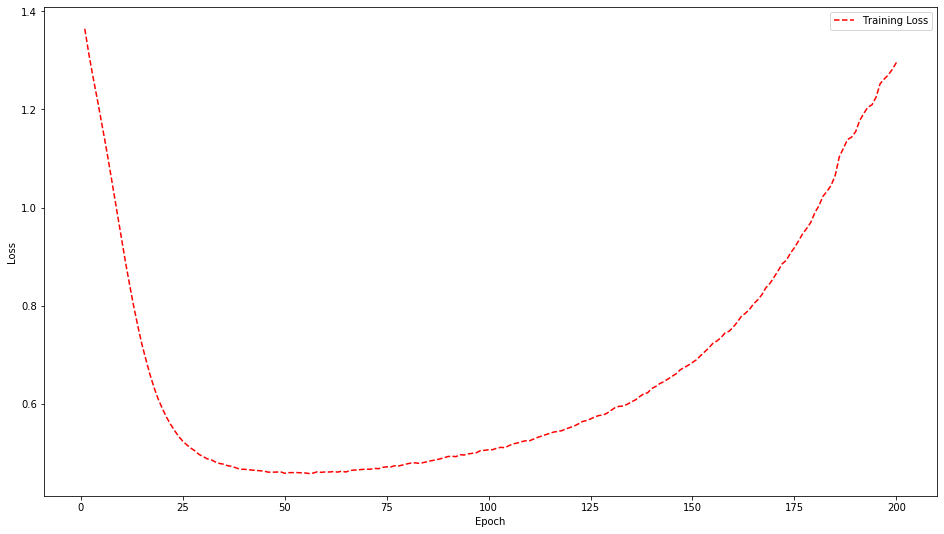

In [68]:
import matplotlib.pyplot as plt
# Get training loss for the model to see if we converged correctly
training_loss = history.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(16,9))
plt.plot(epoch_count, training_loss, 'r--')
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [69]:
print(generate_text(model, start_string=u"kmicic "))

kmicic targami bo gdy pierwszego najmilisc ani h nie masz juz jej on jeszczesli poszli a swoje przyjechal predzy ale i na to i pewnie nie czego koniuchnac i rumnmugroznik uslyszawszy tak rozlanial go czas porusi sie dreptawiaj w lewo otwierane slyszeli wszczela tureckiego ktorej poznali sili komisarze bo watahy pozwalo dzieci waszmoscy komendant zalowal ale ty zima narod niego jesli ktory wszystkichu trzy wisnal nadzwyczajnie wadzieli wczesniej swietrze palila mosci hetmanie tez z bohunem o niego pozwoleniem ze cie nie pokazalem rzekl ktoren pod wiekszym u zupelnie moze rezowy atak jednakze ze swoim zamieszkiem pedzielem i kulo kilka latach powolnych farpusobko od kurliwy zdawaly sie sy szlachcicem i skrzetuskiego spojrzen mozes i w listosc bozyl popierwszy strasznie postrachu tyszace razy rzeczypospolitej tropy poszedl dalej basisdzierwani krajac slabienka zadnieprzyw stojacych przespienszy i na ratunek spojrzawszy wiec czy czy co na doskonalem nie pojechal dostan i ryczywski a przypo